In [1]:
#import a bunch of stuff

import torch
import torch.nn as nn
import torch.nn.functional as Fn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

import os
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

In [36]:
#storing the names of your images and paintings in a list

dir = '../dataset/monet2photo'
train_paintings_dir = dir + '/trainA/'
train_photos_dir = dir + '/trainB/'

paintings_addr = [train_paintings_dir+i for i in os.listdir(train_paintings_dir)]
photos_addr = [train_photos_dir+i for i in os.listdir(train_photos_dir)]   

print(len(paintings_addr),len(photos_addr))

1072 6287


In [3]:
#Preprocessing data so that every value in the image array is between -1 and 1. 

def create_train_sets(paintings_addr, photos_addr):
    
    X_train, Y_train = np.zeros((1072, 3, 128, 128), dtype=np.float32), np.zeros((6287, 3, 128, 128), dtype=np.float32)
    
    for i in range(len(paintings_addr)):
        temp_np = np.asarray(Image.open(paintings_addr[i]).resize((128, 128), Image.ANTIALIAS))  #resizing the image to 128x128
        X_train[i] = temp_np.transpose(2, 0, 1)
        X_train[i] /= 255
        X_train[i] = X_train[i] * 2 -  1
        
    for i in range(len(photos_addr)):
        temp_np = np.asarray(Image.open(photos_addr[i]).resize((128, 128), Image.ANTIALIAS))
        Y_train[i] = temp_np.transpose(2, 0, 1)
        Y_train[i] /= 255
        Y_train[i] = Y_train[i] * 2 -  1
    
    return X_train, Y_train

In [4]:
#X_train, Y_train = create_train_sets(paintings_addr, photos_addr)  

In [5]:
#Saving is optional
#np.save('./npfile/X_train', X_train)
#np.save('./npfile/Y_train', Y_train)

In [6]:
#Loading saved npy files
X_train = np.load('./npfile/X_train.npy')
Y_train = np.load('./npfile/Y_train.npy')

In [7]:
X_tensor = torch.from_numpy(X_train)                #Creating Tensors which will later be wrapped into variables
Y_tensor = torch.from_numpy(Y_train)

In [8]:
class discriminator_nonpatch(nn.Module):
    def __init__(self):
        super(discriminator_nonpatch, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2)
        self.bn3 = nn.BatchNorm2d(256)
        
        self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2)
        self.bn4 = nn.BatchNorm2d(512)
        
        self.conv5 = nn.Conv2d(512, 512, kernel_size=6, stride=1)
        
        self.head = nn.Linear(512, 1)
        
    def forward(self, input):
        x = Fn.leaky_relu(self.conv1(input), negative_slope=0.2)
        x = Fn.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.2)
        x = Fn.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.2)
        x = Fn.leaky_relu(self.bn4(self.conv4(x)), negative_slope=0.2)
        x = Fn.leaky_relu(self.conv5(x), negative_slope=0.2)
        
        x = x.view(x.size(0), -1)
        x = self.head(x)
        
        return Fn.sigmoid(x)

In [9]:
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2)
        self.bn3 = nn.BatchNorm2d(256)
        
        self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2)
        self.bn4 = nn.BatchNorm2d(512)
        
        self.conv5 = nn.Conv2d(512, 512, kernel_size=2, stride=1)
        
        self.head = nn.Linear(512, 1)
        
    def forward(self, input):
        x = Fn.leaky_relu(self.conv1(input), negative_slope=0.2)
        x = Fn.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.2)
        x = Fn.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.2)
        x = Fn.leaky_relu(self.bn4(self.conv4(x)), negative_slope=0.2)
        x = Fn.leaky_relu(self.conv5(x), negative_slope=0.2)
        
        x = x.view(x.size(0), -1)
        x = self.head(x)
        
        return Fn.sigmoid(x)

In [10]:
class generator(nn.Module):         #padding concerns: reflection? What exactly is the concept behind convTranspose?
    
    def __init__(self):
        super(generator, self).__init__()
        
        #c7s1-32
        self.r1 = nn.ReflectionPad2d(3)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=7, stride=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        #d64
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        #d128
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        #R128
        self.r4 = nn.ReflectionPad2d(1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.r5 = nn.ReflectionPad2d(1)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn5 = nn.BatchNorm2d(128)
        
        #R128
        self.r6 = nn.ReflectionPad2d(1)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn6 = nn.BatchNorm2d(128)
        
        self.r7 = nn.ReflectionPad2d(1)
        self.conv7 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn7 = nn.BatchNorm2d(128)
        
        #R128
        self.r8 = nn.ReflectionPad2d(1)
        self.conv8 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn8 = nn.BatchNorm2d(128)
        
        self.r9 = nn.ReflectionPad2d(1)
        self.conv9 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn9 = nn.BatchNorm2d(128)
        
        #R128
        self.r10 = nn.ReflectionPad2d(1)
        self.conv10 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn10 = nn.BatchNorm2d(128)
        
        self.r11 = nn.ReflectionPad2d(1)
        self.conv11 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn11 = nn.BatchNorm2d(128)
        
        #R128
        self.r12 = nn.ReflectionPad2d(1)
        self.conv12 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn12 = nn.BatchNorm2d(128)
        
        self.r13 = nn.ReflectionPad2d(1)
        self.conv13 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn13 = nn.BatchNorm2d(128)
        
        #R128
        self.r14 = nn.ReflectionPad2d(1)
        self.conv14 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn14 = nn.BatchNorm2d(128)
        
        self.r15 = nn.ReflectionPad2d(1)
        self.conv15 = nn.Conv2d(128, 128, kernel_size=3)
        self.bn15 = nn.BatchNorm2d(128)
        
        #u64
        self.uconv16 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn16 = nn.BatchNorm2d(64)
        
        #u32
        self.uconv17 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn17 = nn.BatchNorm2d(32)
        
        #c7s1-3
        self.r18 = nn.ReflectionPad2d(3)
        self.conv18 = nn.Conv2d(32, 3, kernel_size=7, stride=1)
        self.bn18 = nn.BatchNorm2d(3)
        
    def forward(self, input):
        
        #c7s1-32
        x = Fn.leaky_relu(self.bn1(self.conv1(self.r1(input))), negative_slope=0.2)
        
        #d64
        x = Fn.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.2)
        
        #d128
        x = Fn.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.2)
        
        #R128
        x1 = Fn.leaky_relu(self.bn4(self.conv4(self.r4(x))), negative_slope=0.2)
        x1 = Fn.leaky_relu(self.bn5(self.conv5(self.r5(x1))), negative_slope=0.2)
        
        x = x + x1
        
        #R128
        x1 = Fn.leaky_relu(self.bn6(self.conv6(self.r6(x))), negative_slope=0.2)
        x1 = Fn.leaky_relu(self.bn7(self.conv7(self.r7(x1))), negative_slope=0.2)
        
        x = x + x1
        
        #R128
        x1 = Fn.leaky_relu(self.bn8(self.conv8(self.r8(x))), negative_slope=0.2)
        x1 = Fn.leaky_relu(self.bn9(self.conv9(self.r9(x1))), negative_slope=0.2)
        
        x = x + x1
        
        #R128
        x1 = Fn.leaky_relu(self.bn10(self.conv10(self.r10(x))), negative_slope=0.2)
        x1 = Fn.leaky_relu(self.bn11(self.conv11(self.r11(x1))), negative_slope=0.2)
        
        x = x + x1
       
        #R128
        x1 = Fn.leaky_relu(self.bn12(self.conv12(self.r12(x))), negative_slope=0.2)
        x1 = Fn.leaky_relu(self.bn13(self.conv13(self.r13(x1))), negative_slope=0.2)
        
        x = x + x1
        
        #R128
        x1 = Fn.leaky_relu(self.bn14(self.conv14(self.r14(x))), negative_slope=0.2)
        x1 = Fn.leaky_relu(self.bn15(self.conv15(self.r15(x1))), negative_slope=0.2)
        
        x = x + x1
        
        #u64
        x = Fn.leaky_relu(self.bn16(self.uconv16(x)), negative_slope=0.2)
        
        #u32
        x = Fn.leaky_relu(self.bn17(self.uconv17(x)), negative_slope=0.2)
        
        #c7s1-3
        x = Fn.leaky_relu(self.bn18(self.conv18(self.r18(x))), negative_slope=0.2)
        
        return Fn.tanh(x)

In [11]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)

In [12]:
def pass_through_discriminator(discriminator, image):
    score, k = 0, Variable(torch.zeros(1)).type(dtype)
    xp, yp = 0, 0
    x, y = 70, 70
    offset = 25
    
    while x < 128:
        while y < 128:
            k += 1
            score += discriminator(image[:, :, xp:x, yp:y])
            yp += offset
            y += offset
            
        xp += offset
        x += offset
        
    return score / k

In [13]:
dtype = torch.FloatTensor

if torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
    
G = generator().type(dtype)
F = generator().type(dtype)

Dg = discriminator().type(dtype)
Df = discriminator().type(dtype)
Dgnp = discriminator_nonpatch().type(dtype)
Dfnp = discriminator_nonpatch().type(dtype)

G.apply(weights_init)
F.apply(weights_init)
Dg.apply(weights_init)
Df.apply(weights_init)

G_optim = optim.Adam(G.parameters(), lr=0.0002)    #Learning rates directly borrowed from the paper
F_optim = optim.Adam(F.parameters(), lr=0.0002)

Dg_optim = optim.Adam(Dg.parameters(), lr=0.0001)
Df_optim = optim.Adam(Df.parameters(), lr=0.0001)

# learning rate decay
G_scheduler = optim.lr_scheduler.StepLR(G_optim, step_size=100, gamma=0.1)
F_scheduler = optim.lr_scheduler.StepLR(F_optim, step_size=100, gamma=0.1)
Dg_scheduler = optim.lr_scheduler.StepLR(Dg_optim, step_size=100, gamma=0.1)
Df_scheduler = optim.lr_scheduler.StepLR(Df_optim, step_size=100, gamma=0.1)


In [14]:
import time

torch.cuda.empty_cache()

epochs = 200
batch_size = 32

G.train()
F.train()
Dg.train()
Df.train()

k = 0

start_time = time.time()   
for epoch in range(epochs):
    print('Epoch number: {0}'.format(epoch))
    
    G_scheduler.step()
    F_scheduler.step()
    Dg_scheduler.step()
    Df_scheduler.step()
    
    for batch in range(X_tensor.size(0) // batch_size):
        if batch % 100 == 0:
            print('**Batch number: {0}**'.format(batch))
        
        painting_real = X_tensor[batch * batch_size: (batch + 1) * batch_size]
        if k!= 6286:
            photo_real = Y_tensor[k % 6287: (k + 1) % 6287]       
        else:
            photo_real = Y_tensor[6286]
            photo_real = photo_real[np.newaxis, ...]
        k += 1
        
        painting_real = Variable(painting_real).type(dtype)
        photo_real = Variable(photo_real).type(dtype)
        
        #Train GAN G
        
        #Train Dg
        photo_fake = G(painting_real)
        
        scores_real = pass_through_discriminator(Dg, photo_real)
        scores_real_np = Dgnp(photo_real)
        scores_fake = pass_through_discriminator(Dg, photo_fake)
        scores_fake_np = Dgnp(photo_fake)
        
        label_fake = Variable(torch.zeros(batch_size)).type(dtype)
        label_real = Variable(torch.ones(batch_size)).type(dtype)
        
        scores_real = (0.8 * scores_real + 0.2 * scores_real_np) 
        scores_fake = (0.8 * scores_fake + 0.2 * scores_fake_np) 
        
        loss1 = torch.mean((scores_real - label_real)**2)
        loss2 = torch.mean((scores_fake - label_fake)**2)
        
        Dg_optim.zero_grad()
        
        loss_dg = (loss1 + loss2)
        if batch % 100 == 0:
            print('Discriminator G loss: {0}'.format(loss_dg.data))
        loss_dg.backward()
        
        Dg_optim.step()

        #Train G
        photo_fake = G(painting_real)
        
        scores_fake = pass_through_discriminator(Dg, photo_fake)
        loss_g = torch.mean((scores_fake - label_real)**2) + 10 * torch.mean(torch.abs(G(F(photo_real)) - photo_real))
        if batch % 100 == 0:
            print('Generator G loss: {0}'.format(loss_g.data))
        
        G_optim.zero_grad()
        loss_g.backward()
        G_optim.step()
        
        #Train GAN F
        
        painting_fake = F(photo_real)
        
        scores_real = pass_through_discriminator(Df, painting_real)
        scores_real_np = Dfnp(painting_real)
        scores_fake = pass_through_discriminator(Df, painting_fake)
        scores_fake_np = Dfnp(painting_fake)
        
        scores_real = (0.8 * scores_real + 0.2 * scores_real_np)
        scores_fake = (0.8 * scores_fake + 0.2 * scores_fake_np)
        
        loss1 = torch.mean((scores_real - label_real)**2)
        loss2 = torch.mean((scores_fake - label_fake)**2)
        
        Df_optim.zero_grad()
        
        loss_df = (loss1 + loss2)
        if batch % 100 == 0:
            print('Discriminator F loss: {0}'.format(loss_df.data))
        loss_df.backward()
        
        Df_optim.step()
        
        #Train F
        
        painting_fake = F(photo_real)
        
        scores_fake = pass_through_discriminator(Df, painting_fake)
        loss_f = torch.mean((scores_fake - label_real)**2) + 10 * torch.mean(torch.abs(F(G(painting_real)) - painting_real))
        if batch % 100 == 0:
            print('Generator F loss: {0}'.format(loss_f.data))
            print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
        
        F_optim.zero_grad()
        loss_f.backward()
        F_optim.step()
        
        
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch number: 0
**Batch number: 0**
Discriminator G loss: 0.47029152512550354


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Generator G loss: 6.2122416496276855
Discriminator F loss: 0.5168684124946594
Generator F loss: 6.113188743591309
Time elapsed: 0.01 min
Epoch number: 1
**Batch number: 0**
Discriminator G loss: 0.3100680112838745
Generator G loss: 5.152649402618408
Discriminator F loss: 0.6062322854995728
Generator F loss: 3.5883727073669434
Time elapsed: 0.51 min
Epoch number: 2
**Batch number: 0**
Discriminator G loss: 0.393076092004776
Generator G loss: 6.0175886154174805
Discriminator F loss: 0.11593981087207794
Generator F loss: 3.7277677059173584
Time elapsed: 1.01 min
Epoch number: 3
**Batch number: 0**
Discriminator G loss: 0.12217389047145844
Generator G loss: 6.370898723602295
Discriminator F loss: 0.08258867263793945
Generator F loss: 3.8960907459259033
Time elapsed: 1.52 min
Epoch number: 4
**Batch number: 0**
Discriminator G loss: 0.052998561412096024
Generator G loss: 4.5825514793396
Discriminator F loss: 0.0649842619895935
Generator F loss: 3.903064250946045
Time elapsed: 2.03 min
Epoch

Epoch number: 38
**Batch number: 0**
Discriminator G loss: 0.0228215791285038
Generator G loss: 3.9176955223083496
Discriminator F loss: 0.02207610383629799
Generator F loss: 3.201530933380127
Time elapsed: 19.56 min
Epoch number: 39
**Batch number: 0**
Discriminator G loss: 0.02110394276678562
Generator G loss: 6.207679748535156
Discriminator F loss: 0.020206060260534286
Generator F loss: 3.15041446685791
Time elapsed: 20.08 min
Epoch number: 40
**Batch number: 0**
Discriminator G loss: 0.02179347351193428
Generator G loss: 5.982105731964111
Discriminator F loss: 0.020021772012114525
Generator F loss: 3.137732982635498
Time elapsed: 20.60 min
Epoch number: 41
**Batch number: 0**
Discriminator G loss: 0.02306772768497467
Generator G loss: 4.940817832946777
Discriminator F loss: 0.020378701388835907
Generator F loss: 3.087475538253784
Time elapsed: 21.11 min
Epoch number: 42
**Batch number: 0**
Discriminator G loss: 0.0229968074709177
Generator G loss: 5.715197563171387
Discriminator F 

Discriminator F loss: 0.0196540504693985
Generator F loss: 2.9497549533843994
Time elapsed: 38.66 min
Epoch number: 76
**Batch number: 0**
Discriminator G loss: 0.019628984853625298
Generator G loss: 5.495874404907227
Discriminator F loss: 0.020457426086068153
Generator F loss: 2.881537675857544
Time elapsed: 39.18 min
Epoch number: 77
**Batch number: 0**
Discriminator G loss: 0.020001213997602463
Generator G loss: 4.130237579345703
Discriminator F loss: 0.019920367747545242
Generator F loss: 2.955777406692505
Time elapsed: 39.70 min
Epoch number: 78
**Batch number: 0**
Discriminator G loss: 0.019601892679929733
Generator G loss: 7.526766777038574
Discriminator F loss: 0.01956310123205185
Generator F loss: 2.9513368606567383
Time elapsed: 40.21 min
Epoch number: 79
**Batch number: 0**
Discriminator G loss: 0.02001856453716755
Generator G loss: 4.797861576080322
Discriminator F loss: 0.01973951980471611
Generator F loss: 2.913642406463623
Time elapsed: 40.73 min
Epoch number: 80
**Batch

Epoch number: 113
**Batch number: 0**
Discriminator G loss: 0.019712556153535843
Generator G loss: 4.043056964874268
Discriminator F loss: 0.02047160640358925
Generator F loss: 2.807464122772217
Time elapsed: 58.28 min
Epoch number: 114
**Batch number: 0**
Discriminator G loss: 0.019635312259197235
Generator G loss: 5.595783233642578
Discriminator F loss: 0.019605541601777077
Generator F loss: 2.8145179748535156
Time elapsed: 58.80 min
Epoch number: 115
**Batch number: 0**
Discriminator G loss: 0.019414134323596954
Generator G loss: 3.7867887020111084
Discriminator F loss: 0.021455425769090652
Generator F loss: 2.7982921600341797
Time elapsed: 59.32 min
Epoch number: 116
**Batch number: 0**
Discriminator G loss: 0.01968427002429962
Generator G loss: 3.1747090816497803
Discriminator F loss: 0.021847758442163467
Generator F loss: 2.808082103729248
Time elapsed: 59.83 min
Epoch number: 117
**Batch number: 0**
Discriminator G loss: 0.01982884854078293
Generator G loss: 5.603283882141113
Di

Generator G loss: 4.005410194396973
Discriminator F loss: 0.019593410193920135
Generator F loss: 2.7156388759613037
Time elapsed: 77.38 min
Epoch number: 151
**Batch number: 0**
Discriminator G loss: 0.021116506308317184
Generator G loss: 6.894183158874512
Discriminator F loss: 0.019222717732191086
Generator F loss: 2.691554546356201
Time elapsed: 77.90 min
Epoch number: 152
**Batch number: 0**
Discriminator G loss: 0.019609741866588593
Generator G loss: 5.238677501678467
Discriminator F loss: 0.020465169101953506
Generator F loss: 2.711674928665161
Time elapsed: 78.41 min
Epoch number: 153
**Batch number: 0**
Discriminator G loss: 0.019930681213736534
Generator G loss: 4.551918029785156
Discriminator F loss: 0.018424775451421738
Generator F loss: 2.694519519805908
Time elapsed: 78.93 min
Epoch number: 154
**Batch number: 0**
Discriminator G loss: 0.019916798919439316
Generator G loss: 3.418574333190918
Discriminator F loss: 0.02047247439622879
Generator F loss: 2.699232339859009
Time 

Generator F loss: 2.678544044494629
Time elapsed: 96.48 min
Epoch number: 188
**Batch number: 0**
Discriminator G loss: 0.020995602011680603
Generator G loss: 4.4719038009643555
Discriminator F loss: 0.0197741761803627
Generator F loss: 2.716000556945801
Time elapsed: 97.00 min
Epoch number: 189
**Batch number: 0**
Discriminator G loss: 0.01986313983798027
Generator G loss: 3.264155864715576
Discriminator F loss: 0.01955552212893963
Generator F loss: 2.695211410522461
Time elapsed: 97.52 min
Epoch number: 190
**Batch number: 0**
Discriminator G loss: 0.01908983662724495
Generator G loss: 3.4427542686462402
Discriminator F loss: 0.01953379064798355
Generator F loss: 2.6843948364257812
Time elapsed: 98.03 min
Epoch number: 191
**Batch number: 0**
Discriminator G loss: 0.019666044041514397
Generator G loss: 4.987663745880127
Discriminator F loss: 0.021022826433181763
Generator F loss: 2.6664345264434814
Time elapsed: 98.55 min
Epoch number: 192
**Batch number: 0**
Discriminator G loss: 0.

In [15]:
#Simple function for unpreprocessing and displaying results

def test_image(img_addr):
    img = Image.open(img_addr)
    img_np = np.zeros((1, 3, 128, 128), dtype=np.float32)
    temp_np = np.asarray(img.resize((128, 128), Image.ANTIALIAS))
    plt.imshow(temp_np)
    
    img_np[0] = temp_np.transpose(2, 0, 1)
    
    img_np /= 255
    img_np = img_np * 2 - 1
    img_tensor = torch.from_numpy(img_np)
    img_var = Variable(img_tensor).type(dtype)
    
    photo_var = G(img_var)
    photo = photo_var.data.cpu().numpy()
    photo = photo[0].transpose(1, 2, 0)
    photo = (photo + 1)/2
    plt.figure()
    plt.imshow(photo)
    
    paint_var = F(photo_var)
    paint = paint_var.data.cpu().numpy()
    paint = paint[0].transpose(1, 2, 0)
    paint = (paint + 1)/2
    plt.figure()
    plt.imshow(paint)

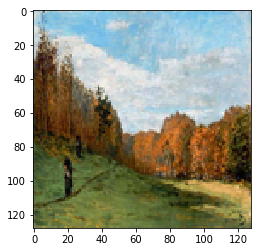

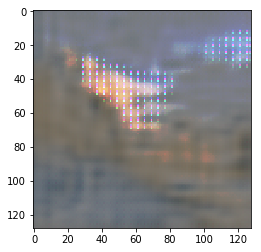

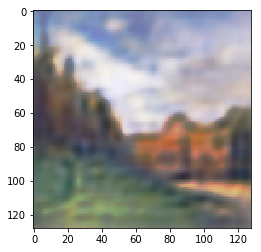

In [19]:
test_image(paintings_addr[30])

In [20]:
def photo2monet(photo_addr):
    img = Image.open(photo_addr)
    img_np = np.zeros((1, 3, 128, 128), dtype=np.float32)
    temp_np = np.asarray(img.resize((128, 128), Image.ANTIALIAS))
    plt.imshow(temp_np)
    
    img_np[0] = temp_np.transpose(2, 0, 1)
    
    img_np /= 255
    img_np = img_np * 2 - 1
    img_tensor = torch.from_numpy(img_np)
    img_var = Variable(img_tensor).type(dtype)
    
    paint_var = F(img_var)
    paint = paint_var.data.cpu().numpy()
    paint = paint[0].transpose(1, 2, 0)
    paint = (paint + 1)/2
    plt.figure()
    plt.imshow(paint)

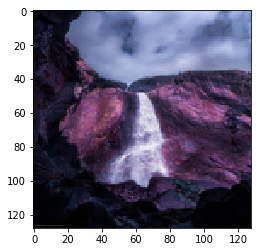

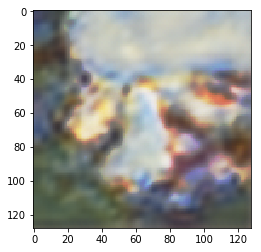

In [23]:
photo2monet(photos_addr[190])

In [25]:
test_paintings_dir = dir + '/testA/'
test_photos_dir = dir + '/testB/'

test_paintings_addr = [test_paintings_dir+i for i in os.listdir(test_paintings_dir)]
test_photos_addr = [test_photos_dir+i for i in os.listdir(test_photos_dir)]   


In [30]:
len(test_photos_addr)

751

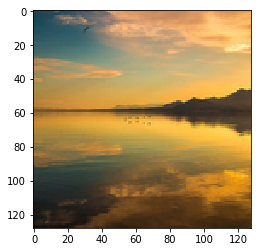

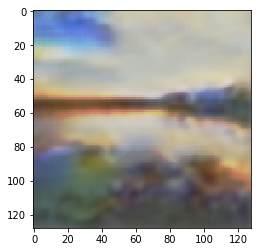

In [32]:
photo2monet(test_photos_addr[290])

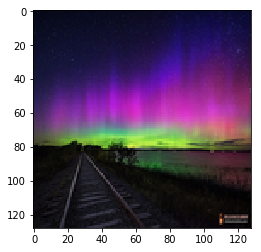

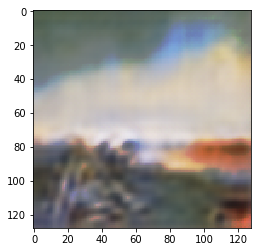

In [33]:
photo2monet(test_photos_addr[90])

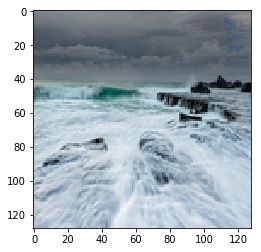

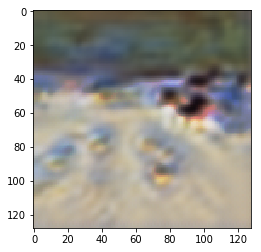

In [34]:
photo2monet(test_photos_addr[20])

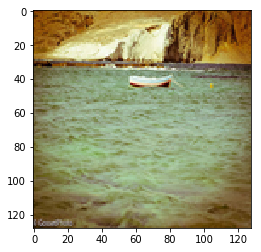

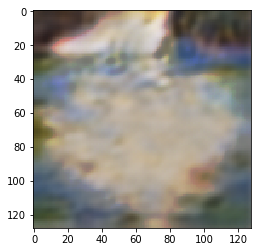

In [35]:
photo2monet(test_photos_addr[30])